# **Q4 - MEMBRANE**

***

In [191]:
%matplotlib inline

## **Step 1 : Create a Mesh**

In [192]:
from polymesh.grid import grid_Q4
import numpy as np

size = Lx, Ly = (10, 10)
shape = nx, ny = (100, 100)

gridparams = {
    'size' : size,
    'shape' : shape,
    'origo' : (0, 0),
    'start' : 0
    }

coordsQ4_, topoQ4 = grid_Q4(**gridparams)
coordsQ4 = np.zeros((coordsQ4_.shape[0], 3))
coordsQ4[:, :2] = coordsQ4_[:, :]

## **Step 2 : Define a Material**

In [193]:
E = 12000
nu = 0.2
t = 0.25
A = np.array([[1, nu, 0], [nu, 1, 0], [0., 0, (1-nu)/2]]) * (t * E /(1-nu**2))

## **Step 3 : Set Boundary Conditions**

In [194]:
# fix points at x==0
cond = (coordsQ4[:, 0] <= 0.001) & (coordsQ4[:, 1] >= (Ly/2))
ebcinds = np.where(cond)[0]
fixity = np.zeros((coordsQ4.shape[0], 2), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load on points at (Lx, Ly)
Fz = -10
cond = (coordsQ4[:, 0] > (Lx-(1e-12))) & (coordsQ4[:, 1] > (Ly-(1e-12)))
nbcinds = np.where(cond)[0]
loads = np.zeros((coordsQ4.shape[0], 2))
loads[nbcinds, 1] = Fz

## **Step 4 : Assembly and Solution**

In [195]:
from sigmaepsilon.solid.fem.mesh import FemMesh
from sigmaepsilon.solid.fem.structure import Structure
from sigmaepsilon.solid.fem.cells import Q4M as Q4

Q4._selective_= False
meshQ4 = FemMesh(coords=coordsQ4, topo=topoQ4, model=A, fixity=fixity, \
    loads=loads, celltype=Q4)
structure = Structure(mesh=meshQ4)

In [196]:
structure.linsolve(permc_spec='NATURAL', sparsify=True)
structure.summary

{'proc': {'time [ms]': 608.8292598724365,
  'N': 20402,
  'use_umfpack': True,
  'permc_spec': 'NATURAL',
  'sparsify': True,
  'solver': 'scipy.sparse.linalg.spsolve',
  'boxing': False,
  'number of elements': 10000,
  'number of nodes': 10201,
  'dofs per node': 2}}

In [197]:
dofsol = np.zeros_like(coordsQ4)
dofsol[:, :2] = structure.mesh.pointdata.dofsol.to_numpy()

In [198]:
structure.mesh.pointdata['x'] = coordsQ4 + dofsol

In [199]:
mb = structure.mesh.to_pv()

In [200]:
mb.GetBlock(0).point_data['dofsol'] = dofsol[:, 1]

In [201]:
#mb.plot(show_edges=False, notebook=False, cpos="xy")

## **Step 5 : Triangulate and Plot**

In [202]:
from polymesh.topo.tr import Q4_to_T3
from polymesh.tri.triang import triangulate
from polymesh.tri.triplot import triplot
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
plt.style.use('dark_background')

points, triangles = Q4_to_T3(structure.mesh.coords(), topoQ4)
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]

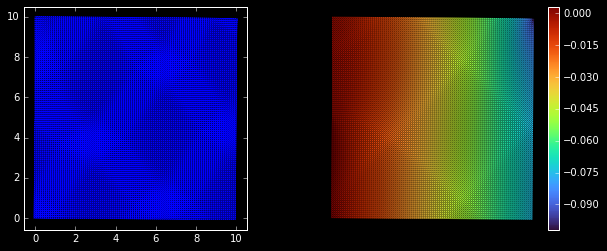

In [203]:
fig = plt.figure(figsize=(10, 4))  # in inches
fig.patch.set_facecolor('black')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig, 
        data=dofsol[:, 1], cmap='turbo', axis='off')

## **Step 6 : Optimize**

In [204]:
%matplotlib qt
plt.style.use('classic')

In [205]:
from pyoneer.mech.topopt.SIMP_OC_FEM import OC_SIMP_COMP as OC

In [206]:
# iteration parameters
OC_params = {
    'p_start' : 1.0,  # SIMP penalty factor
    'p_stop' : 3.0,
    'p_inc' : 0.1,
    'p_step' : 5,
    'q' : 0.5,  # smoothing factor
    'vfrac' : 0.4,  # fraction of target volume over initial volume
    'dtol' : 0.1,  #  to control maximum change in the variables
    'r_min' : 1.1 * max(Lx/nx, Ly/ny),  # for the density filter
    'miniter' : 30,
    'maxiter' : 100
    }

In [207]:
from pyoneer.math import histogram
from matplotlib import gridspec
import matplotlib as mpl
from IPython.display import display, clear_output

fig = plt.figure(figsize=(10, 4))  # in inches
#fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(2, 3, width_ratios=[6, 2, 4])

uz = structure.mesh.pointdata.dofsol.to_numpy()[nbcinds, 1].min()
nCell = structure.mesh.number_of_cells()
history = {'comp' : [], 'vol' : [], 'x' : []}
history['comp'].append(2*uz*Fz) 
history['x'].append(np.random.rand(nCell))
history['vol'].append(Lx*Ly)

nbins = 10
hist, bin_centers = histogram(history['x'][-1], nbins)
hist = hist.astype(float)
hist /= hist.max()
ax1 = fig.add_subplot(gs[:, 1])
ax1.set_facecolor('white')
bars = ax1.barh(bin_centers, hist, 0.5/nbins)
ax1.set_xlim(0, 1)
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 2])
ax2.axhline(y=history['comp'][-1], color="r", linestyle="--", lw=0.5)
#ax2.set_ylim(0, history['comp'][-1]*1.2)

ax3 = fig.add_subplot(gs[1, 2])
ax3.set_ylim(0, history['vol'][-1])
ax3.axhline(y=history['vol'][-1]*OC_params['vfrac'], 
            color="r", linestyle="--", lw=0.5)

cmap = plt.cm.winter  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)
#cmaplist[-1] = (1., 0., 0., 1.0)
#cmaplist.reverse()
cmaplist[0] = (1., 1., 1., 1.0)
cmaplist[-1] = (1., 0., 0., 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 10, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax4 = fig.add_subplot(gs[:, 0])
points, triangles, edata = \
    Q4_to_T3(coordsQ4, topoQ4, edata=history['x'][-1])
triobj = triangulation(points=points[:, :2], triangles=triangles)[-1]
trifield = triplot(triobj, ax=ax4, data=edata, axis='off', 
                   lw=0.0, fig=fig, cmap=cmap)[0]


def callback_qt(i, comp, vol, dens):
    history['comp'].append(comp)
    history['vol'].append(vol)
    history['x'].append(dens)
    fig.canvas.manager.window.raise_()
    hist, _ = histogram(dens, nbins)
    hist = hist.astype(float)
    hist /= hist.max()
    for bar, h in zip(bars, hist):
        bar.set_width(h)
    ax2.plot(i, comp, marker='o', c='b', markersize='1')
    ax3.plot(i, vol, marker='*', c='g', markersize='1')
    ax2.set_xlim(0, i+1)
    ax3.set_xlim(0, i+1) 
    *_, edata = Q4_to_T3(coordsQ4, topoQ4, edata=dens)
    trifield.set_array(edata)
    fig.canvas.draw()
    fig.canvas.flush_events()
    
def callback_inline(i, comp, vol, dens):
    history['comp'].append(comp)
    history['vol'].append(vol)
    history['x'].append(dens)
    hist, _ = histogram(dens, nbins)
    hist = hist.astype(float)
    hist /= hist.max()
    
    ax1.cla()
    ax1.barh(bin_centers, hist, 0.5/nbins)
    ax2.plot(i, comp, marker='o', c='b', markersize='1')
    ax3.plot(i, vol, marker='*', c='g', markersize='1')
    ax4.cla()
    *_, edata = Q4_to_T3(coordsQ4, topoQ4, edata=dens)
    triplot(triobj, ax=ax4, data=edata, axis='off', lw=0.0, 
            fig=fig, cmap=cmap)[0]
    
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)
    
    

In [208]:
res, sum = OC(structure.mesh,  summary=True, callback=callback_qt, **OC_params)
ax2.set_xlim(0, len(history['comp']))
ax3.set_xlim(0, len(history['comp']))

(0.0, 99.0)